# Segmentation with UNet

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
from random_shapes_dataset import ShapesDataset

## Helper functions for visualizing the dataset

In [3]:
def masks_to_rgb(masks):
    colors = torch.FloatTensor([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228), (56, 34, 132), (160, 194, 56)])

    masks = masks.permute(0, 2, 3, 1)
    above_threshold = (masks > 0.5).float()

    count = torch.sum(above_threshold, dim=-1, keepdim=True)
    img = torch.einsum('bhwm,mc->bhwc', above_threshold, colors)

    img = img / count.float()
    img = torch.clamp(img, 0, 255).to(torch.uint8)

    return img.contiguous()

def reverse_transform(inp):
    inp = inp.repeat(1, 3, 1, 1)
    inp = inp.numpy().transpose((0, 2, 3, 1))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

def plot_side_by_side(img_arrays):
    flatten_list = []
    for row in zip(*img_arrays):
        for img in row:
            flatten_list.append(img)

    ncol = len(img_arrays)
    nrow = len(flatten_list) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(flatten_list)):
        if nrow == 1:
            ax = plots[i % ncol]
        else:
            ax = plots[i // ncol, i % ncol]
        ax.imshow(flatten_list[i])

## Dataset

In [4]:
# use same transform for train/val for this example
train_ds = ShapesDataset(4096)
val_ds   = ShapesDataset(256)

In [5]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=0)

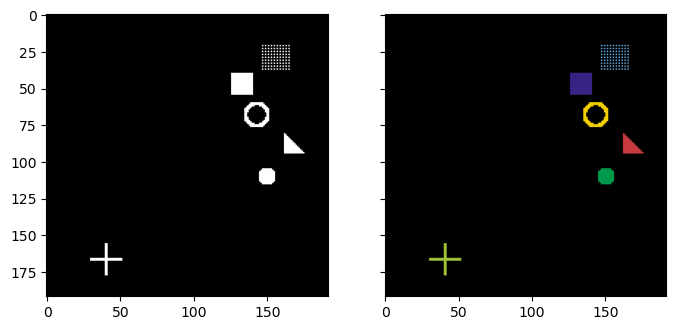

In [6]:
# Get a batch of training data
idx = np.random.randint(0, len(train_ds))
img, mask = train_ds[idx]

img = img.unsqueeze(0)
mask = mask.unsqueeze(0)

img = reverse_transform(img)
mask = masks_to_rgb(mask)

plot_side_by_side([img, mask])

## Model

Following [1505.04597](https://arxiv.org/abs/1505.04597)

![UNet Architecture](unet.png)

In [7]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)
        
        out = self.conv_last(x)

        return out

In [20]:
model = UNet(6)
if torch.cuda.is_available():
    model = model.cuda()
summary(model, input_size=(1, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]             640
              ReLU-2         [-1, 64, 192, 192]               0
            Conv2d-3         [-1, 64, 192, 192]          36,928
              ReLU-4         [-1, 64, 192, 192]               0
         MaxPool2d-5           [-1, 64, 96, 96]               0
            Conv2d-6          [-1, 128, 96, 96]          73,856
              ReLU-7          [-1, 128, 96, 96]               0
            Conv2d-8          [-1, 128, 96, 96]         147,584
              ReLU-9          [-1, 128, 96, 96]               0
        MaxPool2d-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 256, 48, 48]         295,168
             ReLU-12          [-1, 256, 48, 48]               0
           Conv2d-13          [-1, 256, 48, 48]         590,080
             ReLU-14          [-1, 256,

## Loss

Segmentation problems often feature relatively small shapes on a large background, causing large class imbalance

==> ***Dice Loss*** is often used in addition to BCE to address this:

### $\mathrm{dice} := 2 \cdot \frac{ \left| y\  \cap \  \hat{y} \right| + s}{ \left| y \ \cup \hat{y} \ \right| + s}$
### $L_\mathrm{dice} = 1 - \mathrm{dice}$

where $s$ (i.e. "smooth") is introduced for stability.

![dice](dice.png)

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (union + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss, bce, dice

## Training

In [10]:
def train_model(model, optimizer, scheduler=None, num_epochs=25, return_dict=None):

    device = torch.device("cpu")
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"Found GPU: {device}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"Found MPS: {device}")

    model.to(device)

    best_loss = 1e10

    if return_dict is None:
        return_dict = {
            'train': {'bce': [], 'dice': [], 'loss': []},
            'val': {'bce': [], 'dice': [], 'loss': []},
            'lrs': []
        }

    for epoch in range(num_epochs):

        # training
        model.train()  # Set model to training mode
        for inputs, labels in tqdm(train_dl):

            # to cuda if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss, bce, dice = calc_loss(outputs, labels)

            loss.backward()
            optimizer.step()

            # storing loss every step
            return_dict['train']['bce'].append(bce.item())
            return_dict['train']['dice'].append(dice.item())
            return_dict['train']['loss'].append(loss.item())


        # validation
        model.eval()  # Set model to evaluation mode
        loss_, bce_, dice_ = 0, 0, 0
        for iter_val, (inputs, labels) in enumerate(val_dl):

            # to cuda if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss, bce, dice = calc_loss(outputs, labels)

                loss_ += loss.item()
                bce_ += bce.item()
                dice_ += dice.item()

        # storing loss every epoch            
        return_dict['val']['bce'].append(bce_ / iter_val)
        return_dict['val']['dice'].append(dice_ / iter_val)
        return_dict['val']['loss'].append(loss_ / iter_val)

        # save the model
        if loss_ < best_loss:
            best_loss = loss_
            torch.save(model.state_dict(), 'saved_model.pt')


        # store the changing lrs, so that we can look at them later
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']

        return_dict['lrs'].append(current_lr)

        print(f'Epoch {epoch + 1}/{num_epochs} (lr: {current_lr:.4f})-> dice: {dice_ / iter_val:.4f}, bce: {bce_ / iter_val:.4f}, loss: {loss_ / iter_val:.4f}')

        if scheduler is not None:
            # update learning rate
            scheduler.step()

    return return_dict

### Train the model

Use a scheduler to decay the learning rate by a factor `gamma` every `step_size` epochs

In [11]:
model = UNet(6)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
lr_sch = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.8)

return_dict = train_model(model, optimizer_ft, lr_sch, num_epochs=20)

Found GPU: cuda:0


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/20 (lr: 0.0010)-> dice: 1.6670, bce: 0.0413, loss: 0.8541


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/20 (lr: 0.0008)-> dice: 1.4074, bce: 0.0482, loss: 0.7278


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/20 (lr: 0.0006)-> dice: 1.1389, bce: 0.0782, loss: 0.6086


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/20 (lr: 0.0005)-> dice: 0.7204, bce: 0.0375, loss: 0.3790


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/20 (lr: 0.0004)-> dice: 0.5642, bce: 0.0273, loss: 0.2957


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/20 (lr: 0.0003)-> dice: 0.5243, bce: 0.0231, loss: 0.2737


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/20 (lr: 0.0003)-> dice: 0.4999, bce: 0.0207, loss: 0.2603


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/20 (lr: 0.0002)-> dice: 0.4457, bce: 0.0195, loss: 0.2326


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/20 (lr: 0.0002)-> dice: 0.2960, bce: 0.0121, loss: 0.1540


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/20 (lr: 0.0001)-> dice: 0.1833, bce: 0.0111, loss: 0.0972


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/20 (lr: 0.0001)-> dice: 0.1430, bce: 0.0102, loss: 0.0766


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/20 (lr: 0.0001)-> dice: 0.1273, bce: 0.0101, loss: 0.0687


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/20 (lr: 0.0001)-> dice: 0.1216, bce: 0.0103, loss: 0.0659


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/20 (lr: 0.0001)-> dice: 0.1144, bce: 0.0092, loss: 0.0618


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/20 (lr: 0.0000)-> dice: 0.1096, bce: 0.0092, loss: 0.0594


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/20 (lr: 0.0000)-> dice: 0.1064, bce: 0.0091, loss: 0.0578


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/20 (lr: 0.0000)-> dice: 0.1070, bce: 0.0087, loss: 0.0578


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/20 (lr: 0.0000)-> dice: 0.1052, bce: 0.0091, loss: 0.0572


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/20 (lr: 0.0000)-> dice: 0.1024, bce: 0.0088, loss: 0.0556


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/20 (lr: 0.0000)-> dice: 0.1006, bce: 0.0086, loss: 0.0546


### Plot the training metrics

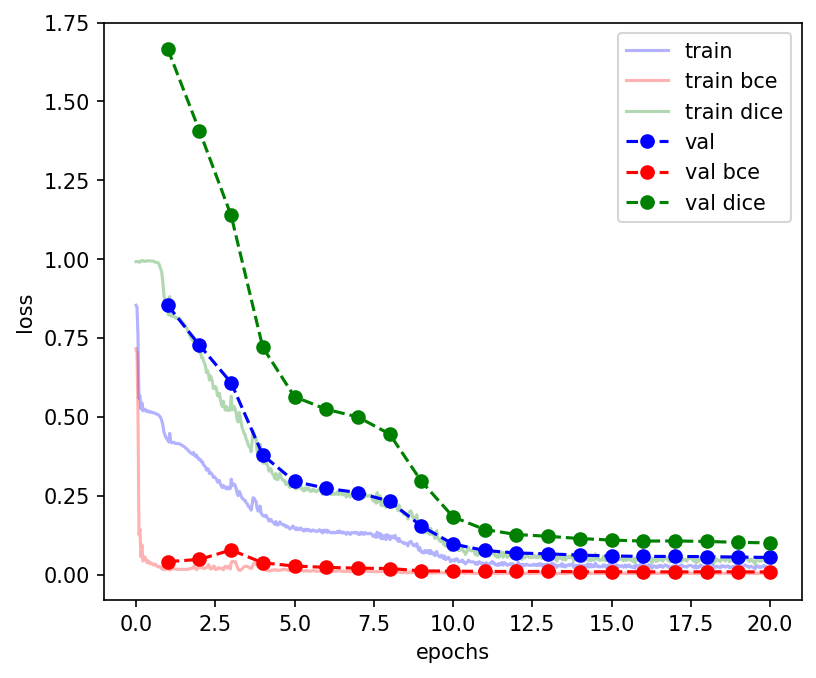

In [15]:
fig = plt.figure(figsize=(6, 5), dpi=150)

ax = fig.add_subplot(1, 1, 1)

n_epochs = len(return_dict['val']['loss'])
xs = np.linspace(0, n_epochs, len(return_dict['train']['loss']))

ax.plot(xs, return_dict['train']['loss'], label='train', c='b', alpha=0.3)
ax.plot(xs, return_dict['train']['bce'], label='train bce', c='r', alpha=0.3)
ax.plot(xs, return_dict['train']['dice'], label='train dice', c='g', alpha=0.3)

xs = np.arange(1, n_epochs + 1)
ax.plot(xs, return_dict['val']['loss'], label='val', c='b', linestyle='--', marker='o')
ax.plot(xs, return_dict['val']['bce'], label='val bce', c='r', linestyle='--', marker='o')
ax.plot(xs, return_dict['val']['dice'], label='val dice', c='g', linestyle='--', marker='o')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

plt.show()

### The learning rate

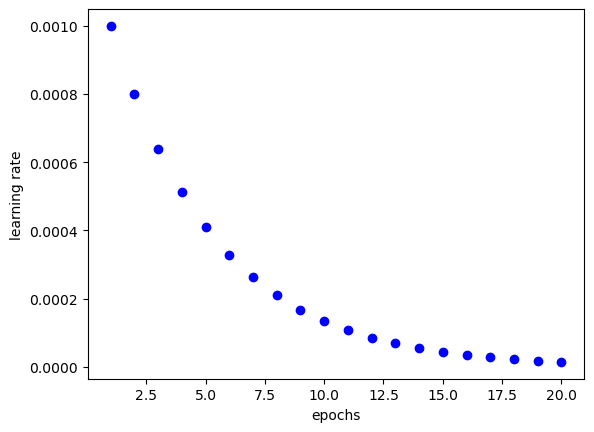

In [ ]:
lrs = return_dict['lrs']
xs = np.arange(1, len(lrs) + 1)

plt.scatter(xs, lrs, label='learning rate', c='b', marker='o')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.show()

## Evaluation

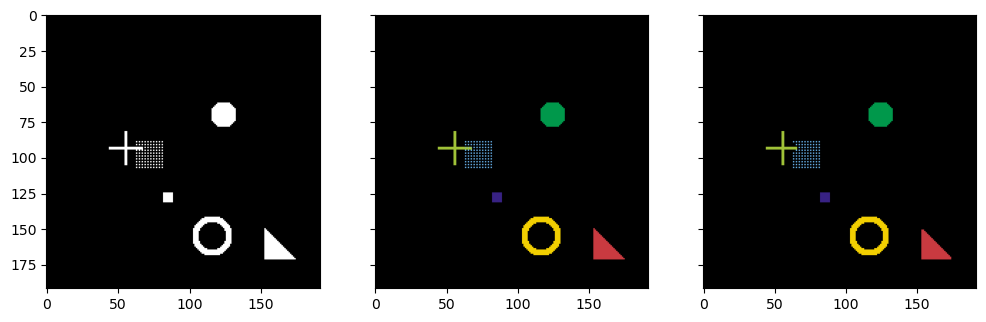

In [18]:
best_model_wts = torch.load('saved_model.pt', map_location='cpu')
model = UNet(6)
model.load_state_dict(best_model_wts)
model = model.to('cpu') 
model.eval()   # Set model to evaluate mode

idx = np.random.randint(0, len(val_ds))
img, mask = val_ds[idx]
img = img.unsqueeze(0)
mask = mask.unsqueeze(0)

pred = model(img) #.to(device))

# Change channel-order and make 3 channels for matplot
img_rgb = reverse_transform(img[0])

# Map each channel (i.e. class) to each color
mask_rgb = masks_to_rgb(mask)
pred_rgb = masks_to_rgb(pred)

plot_side_by_side([img_rgb, mask_rgb, pred_rgb])
plt.show()